In [33]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import quickshift
from sklearn.linear_model import Ridge
from scipy.stats import kendalltau, spearmanr
import warnings

In [34]:
# Suppress harmless warnings from scikit-image
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.eval()  # Set model to evaluation mode

# Define the image preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]   
    )
])

# Load the ImageNet class index mapping
with open("imagenet_class_index.json") as f:
    class_idx = json.load(f)
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
idx2synset = [class_idx[str(k)][0] for k in range(len(class_idx))]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/home/aryant2/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aryant2/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
def lime_explanation(pil_image, model, preprocess_fn, predicted_idx, device, num_samples=1000, num_superpixels=50):
    img_resized = pil_image.resize((224, 224))
    image_np = np.array(img_resized)
    segments_slic = quickshift(image_np, kernel_size=4, max_dist=200, ratio=0.2)
    num_superpixels_found = len(np.unique(segments_slic))

    Z_features = []  # Perturbation vectors (z')
    Z_labels = []    # Model predictions f(z)
    Z_distances = [] # Proximity pi_x

    original_feature_vec = np.ones(num_superpixels_found)

    #Sample N perturbations
    for _ in range(num_samples):
        # Create interpretable perturbation z'
        z_prime = np.random.randint(0, 2, num_superpixels_found)
        
        # Convert z' to image z (h_x)
        temp_img = image_np.copy()
        for sp_idx in range(num_superpixels_found):
            if z_prime[sp_idx] == 0:
                temp_img[segments_slic == sp_idx] = 0 # Turn off super-pixel
        
        perturbed_pil_img = Image.fromarray(temp_img)
        # Get model prediction f(z)
        input_tensor = preprocess_fn(perturbed_pil_img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
        
        probabilities = F.softmax(output[0], dim=0)
        score = probabilities[predicted_idx].item()
        # Calculate proximity π_x and store
        # We use cosine distance and an RBF kernel
        dist = 1.0 - np.dot(z_prime, original_feature_vec) / (np.linalg.norm(z_prime) * np.linalg.norm(original_feature_vec))
        sigma = 0.25
        proximity = np.exp(-dist**2 / sigma**2) 
        Z_features.append(z_prime)
        Z_labels.append(score)
        Z_distances.append(proximity)

    # Fit weighted linear model (g)
    interpretable_model = Ridge(alpha=1.0)
    interpretable_model.fit(
        np.array(Z_features), 
        np.array(Z_labels), 
        sample_weight=np.array(Z_distances)
    )
    lime_weights = interpretable_model.coef_
    return lime_weights, segments_slic

In [ ]:
def smoothgrad_explanation(input_tensor_3d, predicted_class, model, device, num_samples=50, noise_level=0.15):
    input_tensor_3d = input_tensor_3d.to(device)
    total_gradients = torch.zeros_like(input_tensor_3d)
    for _ in range(num_samples):
        # gaussian noise: z = x + e
        noise = torch.randn_like(input_tensor_3d) * noise_level
        noisy_input = input_tensor_3d + noise
        #  gradient w.r.t. noisy input
        noisy_input.requires_grad = True
        output = model(noisy_input.unsqueeze(0)) 
        score = output[0, predicted_class]
        model.zero_grad()
        score.backward()
        total_gradients += noisy_input.grad.data
    # Average the gradients
    smooth_grad = total_gradients / num_samples
    # Take abs value and sum across channels for a 2D map
    smooth_grad_map = torch.abs(smooth_grad).sum(dim=0).cpu().numpy()
    # Normalize for better visualization
    max_val = np.max(smooth_grad_map)
    min_val = np.min(smooth_grad_map)
    smooth_grad_map = (smooth_grad_map - min_val) / (max_val - min_val + 1e-10)
    return smooth_grad_map


In [62]:
def compute_ranking_correlation(lime_weights, smoothgrad_map_2d, lime_segments):
    num_superpixels = len(lime_weights)
    smoothgrad_superpixel_ranking = []
    for sp_idx in range(num_superpixels):
        mask = (lime_segments == sp_idx)
        if np.sum(mask) > 0:
            avg_importance = np.mean(smoothgrad_map_2d[mask])
            smoothgrad_superpixel_ranking.append(avg_importance)
        else:
            smoothgrad_superpixel_ranking.append(0)
    lime_ranking = np.array(lime_weights)
    sg_ranking = np.array(smoothgrad_superpixel_ranking)
    kendall_corr, _ = kendalltau(lime_ranking, sg_ranking)
    spearman_corr, _ = spearmanr(lime_ranking, sg_ranking)
    return kendall_corr, spearman_corr


def visualize_plot(pil_image, lime_weights, lime_segments, smoothgrad_map_2d,
                   predicted_label):
    
    img_resized = pil_image.resize((224, 224))
    image_np = np.array(img_resized)
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(img_resized)
    axes[0].set_title(f'Input Image with Pred Label: {predicted_label}')
    axes[0].axis('off')

    lime_viz_img = np.zeros_like(image_np)
    max_abs_weight = np.max(np.abs(lime_weights))
    
    for sp_idx, weight in enumerate(lime_weights):
        mask = (lime_segments == sp_idx)
        if weight > 0: # Positive importance = Green
            lime_viz_img[mask] = [0, int(255 * (weight / max_abs_weight)), 0]
        else: # Negative importance = Red
            lime_viz_img[mask] = [int(255 * abs(weight / max_abs_weight)), 0, 0]
            
    axes[1].imshow(lime_viz_img)
    axes[1].set_title('LIME Explanation')
    axes[1].axis('off')

    axes[2].imshow(img_resized, alpha=0.6)
    axes[2].imshow(smoothgrad_map_2d, cmap='hot', alpha=0.4)
    axes[2].set_title('SmoothGrad (Overlay)')
    axes[2].axis('off')

    im_sg = axes[3].imshow(smoothgrad_map_2d, cmap='hot')
    axes[3].set_title('SmoothGrad (Raw Heatmap)')
    axes[3].axis('off')

    fig.colorbar(im_sg, ax=axes[3], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

****************************************


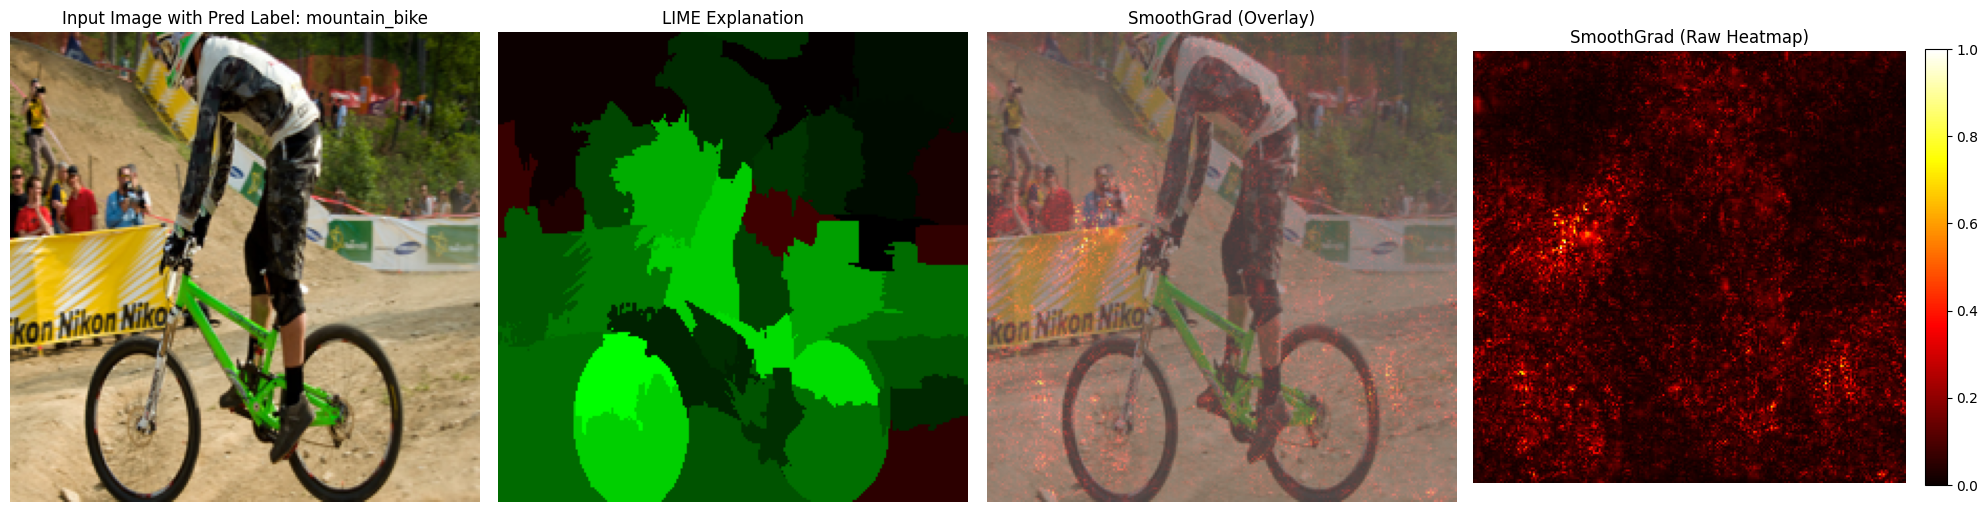

For mountain_bike.JPEG with predicted label: mountain_bike with score: 0.9626, Kendall-Tau: 0.2763, Spearman: 0.4090
****************************************
****************************************


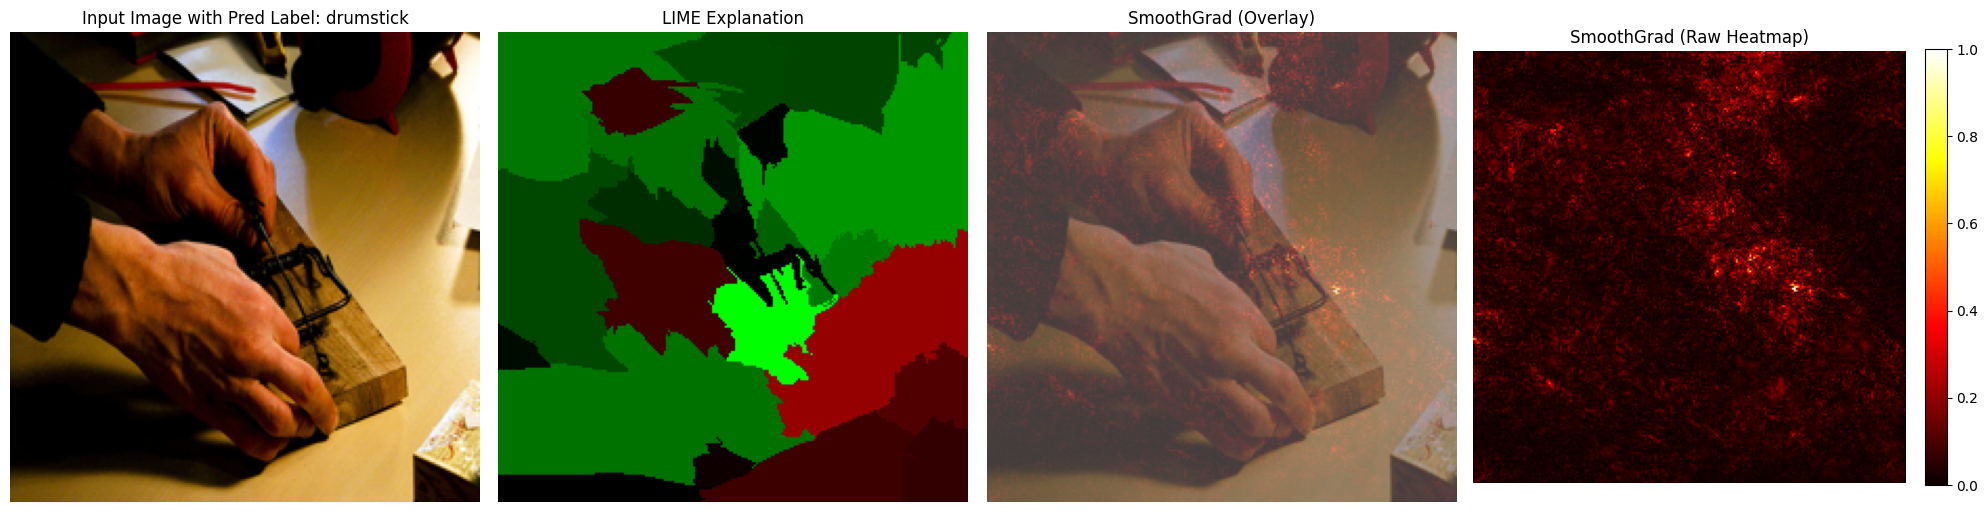

For mousetrap.JPEG with predicted label: drumstick with score: 0.1298, Kendall-Tau: 0.2411, Spearman: 0.4130
****************************************
****************************************


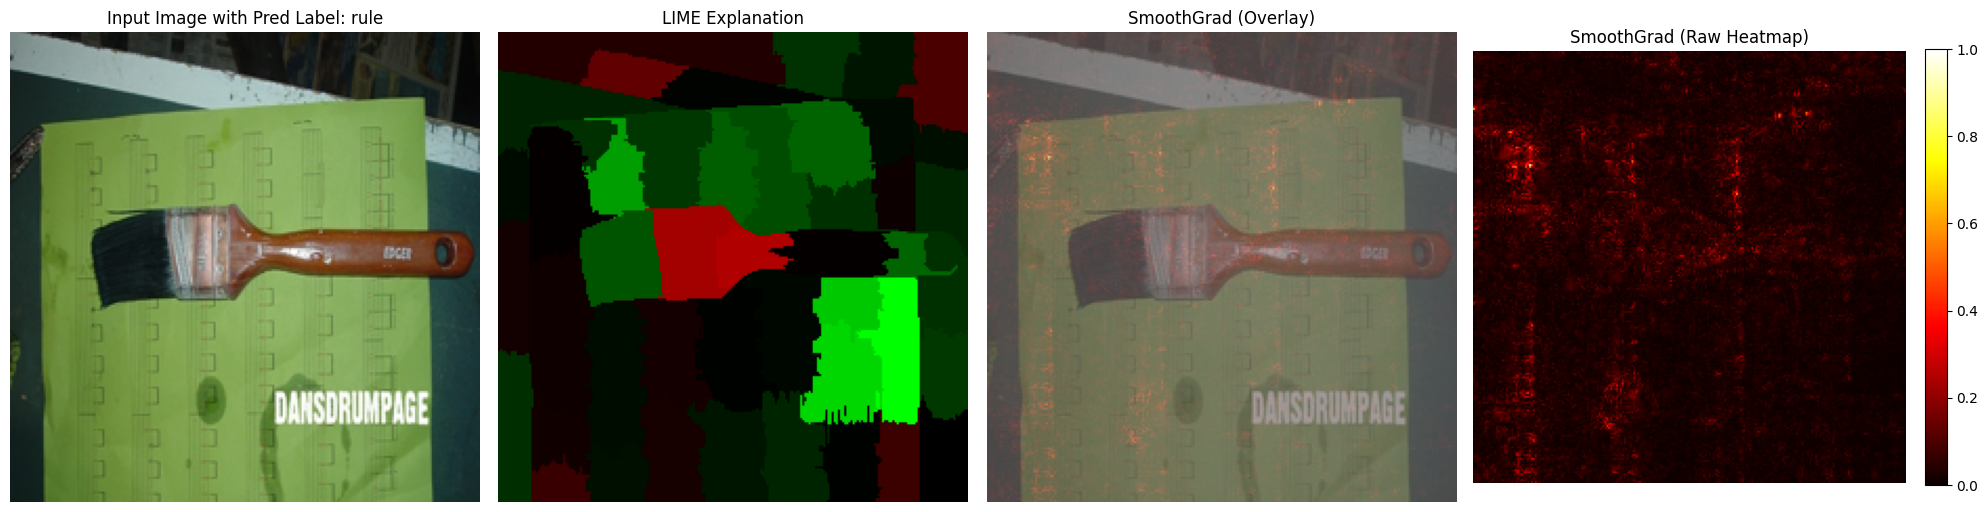

For paintbrush.JPEG with predicted label: rule with score: 0.2365, Kendall-Tau: -0.0816, Spearman: -0.1295
****************************************
****************************************


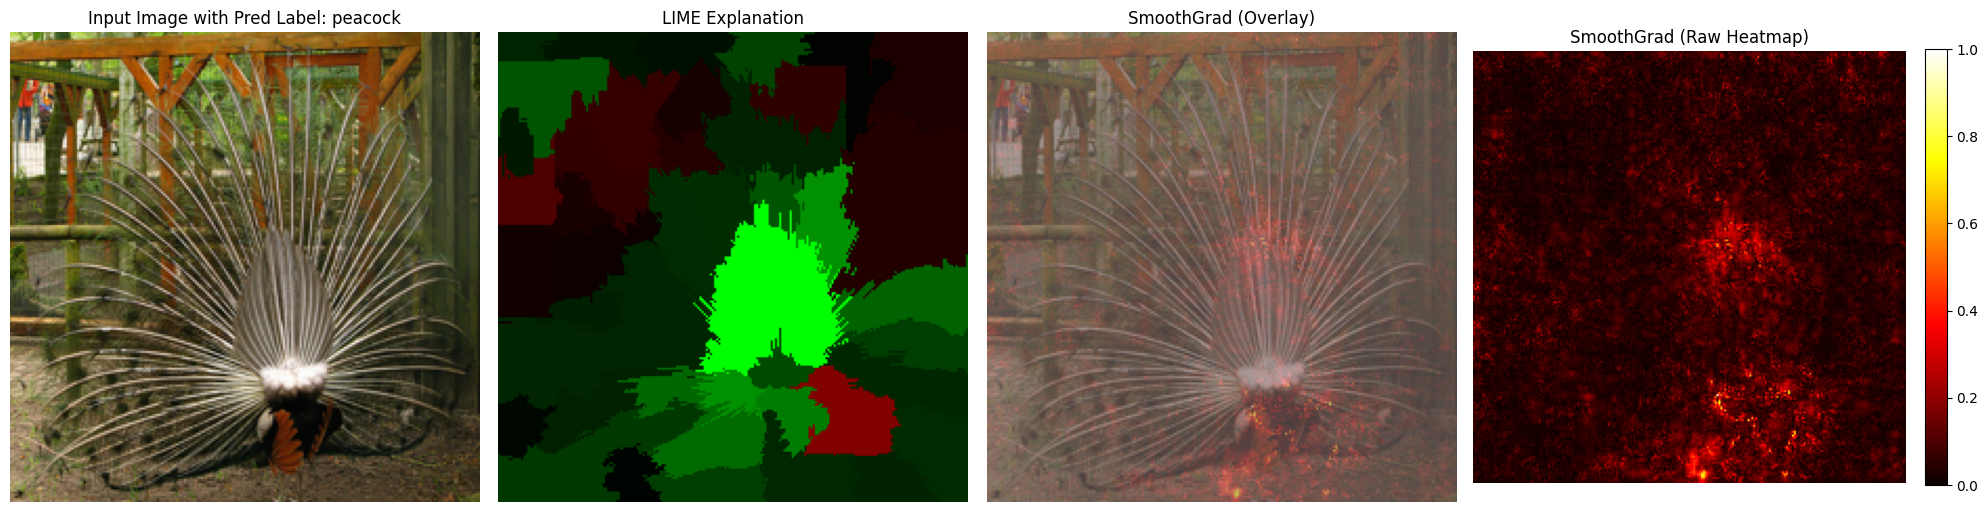

For peacock.JPEG with predicted label: peacock with score: 0.9900, Kendall-Tau: 0.2606, Spearman: 0.3744
****************************************
****************************************


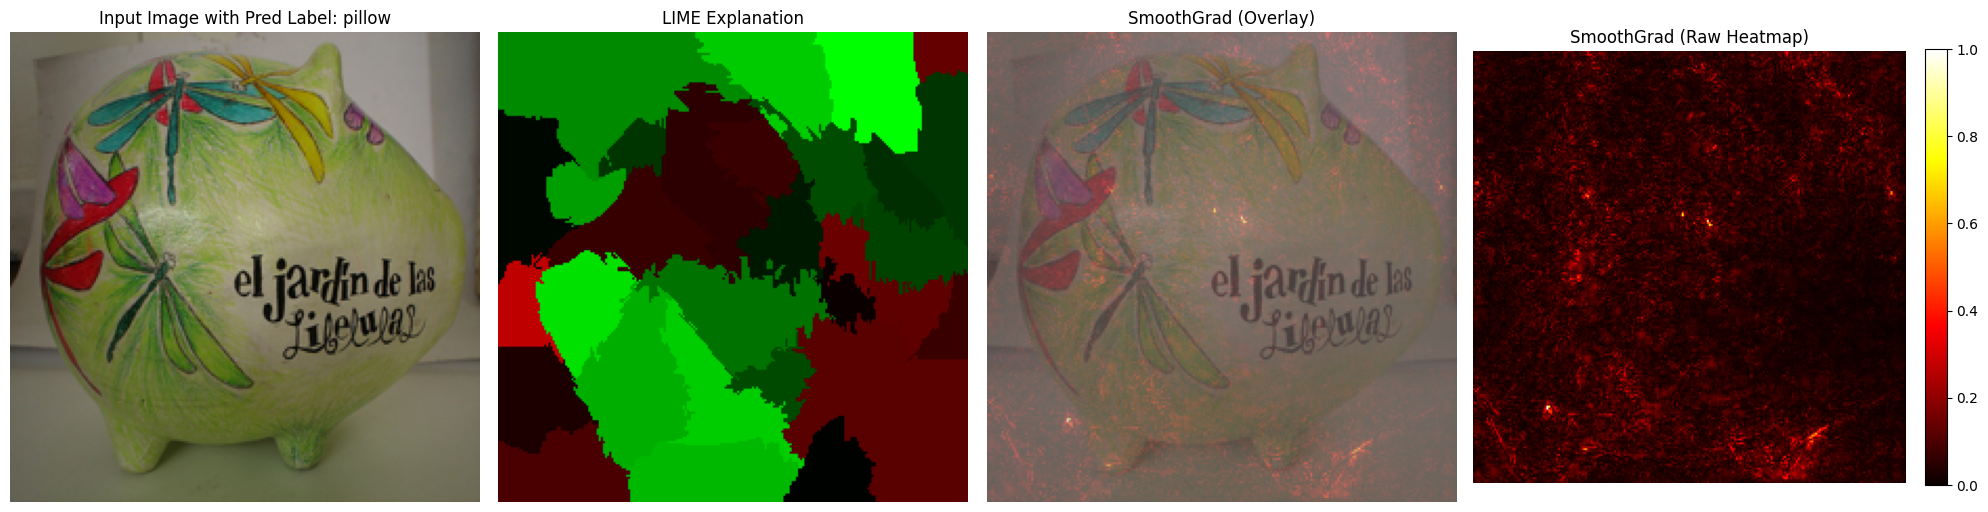

For piggy_bank.JPEG with predicted label: pillow with score: 0.3406, Kendall-Tau: 0.2828, Spearman: 0.3949
****************************************


In [63]:
imagenet_path = './imagenet_samples'
image_names = os.listdir(imagenet_path) 

results = [] 

for img_name in sorted(image_names):
    print("*"*40)
    my_img_path = os.path.join(imagenet_path, img_name)
    input_image_pil = Image.open(my_img_path).convert('RGB')
    input_tensor = preprocess(input_image_pil)
    input_batch = input_tensor.unsqueeze(0).to(device)  
    with torch.no_grad():
        output = model(input_batch)
    predicted_idx = torch.max(output, 1)[1].item()
    predicted_synset = idx2synset[predicted_idx]
    predicted_label = idx2label[predicted_idx]
    score = F.softmax(output, dim=1)[0, predicted_idx].item()
    #lime explanation
    lime_weights, lime_segments = lime_explanation(input_image_pil, model, preprocess, predicted_idx, device)
    #smoothgrad explanation
    smoothgrad_map = smoothgrad_explanation(input_tensor, predicted_idx, model, device)
    
    # Quantitative Comparison 
    kendall, spearman = compute_ranking_correlation(lime_weights, smoothgrad_map, lime_segments)
    visualize_plot(input_image_pil, lime_weights, lime_segments, smoothgrad_map, predicted_label)
    print(f"For {img_name} with predicted label: {predicted_label} with score: {score:.4f}, Kendall-Tau: {kendall:.4f}, Spearman: {spearman:.4f}")
    results.append({'image': img_name,'prediction': predicted_label,'kendall': kendall,'spearman': spearman})
    print("*"*40)

